# Fragrantica perfume review clasifier (LSTM with stopword removed)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from os import path
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Model Name
MODEL_NAME = 'lstm_with_stopword_removed_01'

# HyperParameters
PAD_LEN = 200
NUM_WORDS = 5000
EMBEDDING = 100
BATCH_SIZE = 128


In [3]:
data_path = '../dataset/dataset_210626_215600.csv'
data_exist = path.exists(data_path)

if not data_exist:
    url = 'https://kyuuuw-nlp-dataset.s3.ap-northeast-2.amazonaws.com/fragrantica/dataset_210626_215600.csv'
    r = requests.get(url, allow_redirects=True)
    open(data_path, 'w').write(r.content)

In [4]:
data = pd.read_csv(data_path)

X_data = data['stopwords_removed']
y_data = data['label']

print(len(X_data))
print(len(y_data))

74779
74779


##### label 의 빈도수 확인

C:\tools\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

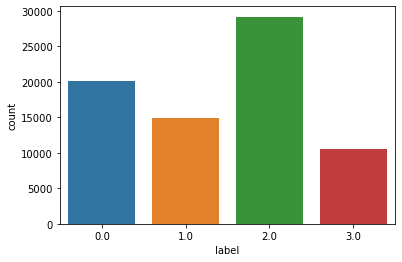

In [5]:
sns.countplot(y_data)

##### 토큰화 및 인덱스 부여

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

print(X_data[0])
print(len(sequences[0]))

KeyboardInterrupt: 

In [ ]:
print(f'리뷰의 최대 길이: {max(len(l) for l in sequences)}')
print(f'리뷰의 평균 길이: {sum(map(len, sequences))/len(sequences)}')
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 인덱스별 단어 표시

In [ ]:
word_to_index = tokenizer.word_index
print(word_to_index)

##### 빈도수 분석

In [ ]:
threshold = 2
total_cnt = len(word_to_index) # 총 단어의 수
rare_cnt = 0 # 등장 빈도 수가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f"등장 빈도가 {threshold}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합(vocabulary)에서 희귀 단어의 비율: {rare_cnt / total_cnt}" )
print(f"전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {rare_freq / total_freq}")

##### 등장 횟수 상위 50000개의 word 만 사용

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

print(sequences[:5])

In [ ]:
print(f'리뷰의 최대 길이: {max(len(l) for l in sequences)}')
print(f'리뷰의 평균 길이: {sum(map(len, sequences))/len(sequences)}')
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, y_data)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

In [ ]:
print(X_train[0])
print(y_train[0])

In [ ]:
# padding and trimming
X_train = pad_sequences(X_train, maxlen=PAD_LEN)
X_test = pad_sequences(X_test, maxlen=PAD_LEN)

In [ ]:
# One hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train[0])

In [ ]:
model = Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING))
model.add(LSTM(EMBEDDING))
model.add(Dense(4, activation='softmax'))

model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('../model/lstm_with_stopword_removed_01.h5', monitor='val_acc', mode='max')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=30, callbacks=[es, mc],
                    validation_data=(X_test, y_test))